In [31]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt

### System parameters

In [8]:
L = 100
x,dx = np.linspace(-5,5,L+1,retstep=True)

## Operators

In [11]:
X = np.diag(x)
# Let's figure out how the momentum operator acts on a state
# P = i * d/dx, so P Psi(x) => i * (Psi(x+dx) - Psi(x)), but we'll make it symmetric:
# P Psi(x) => i * ( (Psi(x + dx) - Psi(x)) + (Psi(x) - Psi(x-dx)) ) = i * (Psi(x+dx) - Psi(x-dx))
# So as a matrix:
P = 1j * (np.diag(np.ones(L), k=1) - np.diag(np.ones(L), k=-1))

## Free particle test

In [61]:
def gaussian(x, x0, sigma):
    normalization = 1/(np.sqrt(2*np.pi)*sigma)
    return np.exp(-1/2 * (x-x0)**2/sigma**2 ) /normalization

In [62]:
H = np.dot(P,P) # Free particle, just P^2

# Time evolution operator
dt = 0.01
U = sp.linalg.expm(1j * H * dt)

After evolution, the wavefunction's norm is: 0.9999999999996253


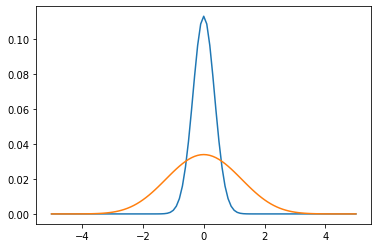

In [72]:
# Initial wavefunction
psi = gaussian(x, 0, 0.5)
# Normalize it
psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

for step in range(1000):
    psi = np.dot(U, psi)

plt.plot(x,np.abs(psi)**2)
print("After evolution, the wavefunction's norm is: {0}".format(np.sum(np.abs(psi)**2)))

## Momentum kick operator

In [73]:
kickstrength = 1
RightKick = sp.linalg.expm( -1j * X * kickstrength )
LeftKick = sp.linalg.expm( 1j * X * kickstrength )

After evolution, the wavefunction's norm is: 0.9999999999996172


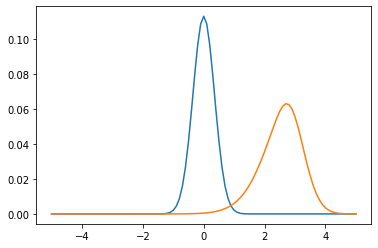

In [74]:
# Initial wavefunction
psi = gaussian(x, 0, 0.5)
# Normalize it
psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

for step in range(1000):
    psi = np.dot(U, psi)
    
    # Kick every so often
    if( step != 0 and step % 100 == 0 ):
        psi = np.dot(RightKick, psi)

plt.plot(x,np.abs(psi)**2)
print("After evolution, the wavefunction's norm is: {0}".format(np.sum(np.abs(psi)**2)))

## Weak measurements

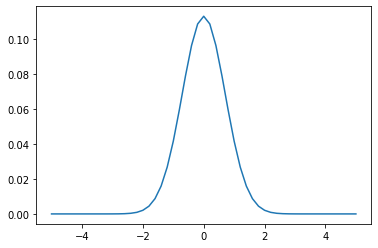

In [238]:
# The number of positions for our needle
Nq = 50
q,dq = np.linspace(-5,5,Nq+1,retstep=True)

# Our needle starts at q = 0
phi = gaussian(q, 0, 1)
phi /= np.linalg.norm(phi)
plt.plot(q, np.abs(phi)**2)

In [239]:
# The momentum operator for q
Pq = 1j * (np.diag(np.ones(Nq), k=1) - np.diag(np.ones(Nq), k=-1))

In [240]:
q_phi = phi
q_p_phi = np.dot(Pq, phi)
q_p2_phi = np.dot( np.dot(Pq, Pq), phi )

coupling_strength = 1
coupling_time = 0.1
cst = coupling_strength * coupling_time

M = []
E = []
for i in range(len(q)):
    M.append( q_phi[i] * np.eye(L+1) - 1j * cst * X * q_p_phi[i] - 0.5 * cst**2 * np.dot(X, X) * q_p2_phi[i] )
    E.append( np.dot(M[i].conj().T, M[i]) )

### Perform measurement

In [241]:
np.random.seed(1990)

Weak measurment probabilities for each q sum to 1.0000000210610136
The weakly measured value is: 0.40
A single weak measurement does almost nothing to the wavefunction, because M_q is almost the identity


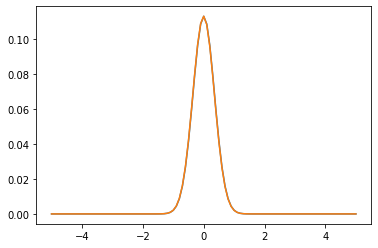

In [242]:
# Initial wavefunction
psi = gaussian(x, 0, 0.5)
# Normalize it
psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

probs = np.zeros(len(q))
for i in range(len(q)):
    # E is Hermitian, so expectation values are real
    probs[i] = np.real( np.dot( psi.conj().T, np.dot( E[i], psi )) )

print("Weak measurment probabilities for each q sum to {0}".format(np.sum(probs)))

# Pick one!
measurement_result = np.random.choice(range(len(q)), p=probs/np.sum(probs))

print("The weakly measured value is: %.2f"%q[measurement_result])
# Update the wavefunction
psi = np.dot(M[measurement_result], psi)
# Normalize it
psi /= np.linalg.norm(psi)

# Update the measurement needle to where we measured
# phi = delta function at q[measurement_result]
# But we will reset phi for the next measurement anyway, so we don't actually need this

plt.plot(x,np.abs(psi)**2)

print("A single weak measurement does almost nothing to the wavefunction, because M_q is almost the identity")

But many weak measurements of position do


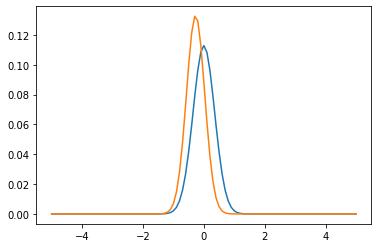

In [246]:
# Initial wavefunction
psi = gaussian(x, 0, 0.5)
# Normalize it
psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

weak_measurements = []
for wm in range(1000):
    probs = np.zeros(len(q))
    for i in range(len(q)):
        # E is Hermitian, so expectation values are real
        probs[i] = np.real( np.dot( psi.conj().T, np.dot( E[i], psi )) )

    # Pick one!
    measurement_result = np.random.choice(range(len(q)), p=probs/np.sum(probs))
    
    weak_measurements.append(q[measurement_result])

    # Update the wavefunction
    psi = np.dot(M[measurement_result], psi)
    # Normalize it
    psi /= np.linalg.norm(psi)

# Update the measurement needle to where we measured
# phi = delta function at q[measurement_result]
# But we will reset phi for the next measurement anyway, so we don't actually need this

plt.plot(x,np.abs(psi)**2)

print("But many weak measurements of position do")

(array([ 16.,  38., 178., 191., 320., 149.,  86.,  17.,   4.,   1.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 <a list of 10 Patch objects>)

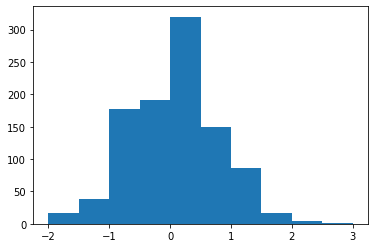

In [247]:
plt.hist(weak_measurements)

## Todo

* Should the needle be uniformly distributed every time instead?
* Implement weak measurements for the momentum of the wavefunction